# Exercise Week 5

- Dave Schurtenberger
- Luca Kyburz
- Pascal Gansner
- Sofia Horlacher

## Forecasting

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_interval
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

from utils import (
    time_plot,
    acf_plot,
    pacf_plot,
    stationarity_tests,
    residual_analysis_plots,
    split_time_series,
    evaluate_forecaster,
    fit_and_forecast,
    plot_fit_and_forecast,
    baseline_forecasting,
    get_figure
)
from data import get_apple_5y, get_switzerland_temperature, compact_to_expanded

## Apple

### 1. Split real-world time series into train/test sets.

In [2]:
data = get_apple_5y().resample('W').mean().ffill()['Close']
full_train, (train, eval_set), test = split_time_series(data, valid_size=0, test_size=0.2)

/Users/sofiahorlacher/VisualStudio/time/notebooks/data.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', period='5y')
[*********************100%***********************]  1 of 1 completed


### 2. Fit ARIMA on training, forecast test observations.

/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/ut

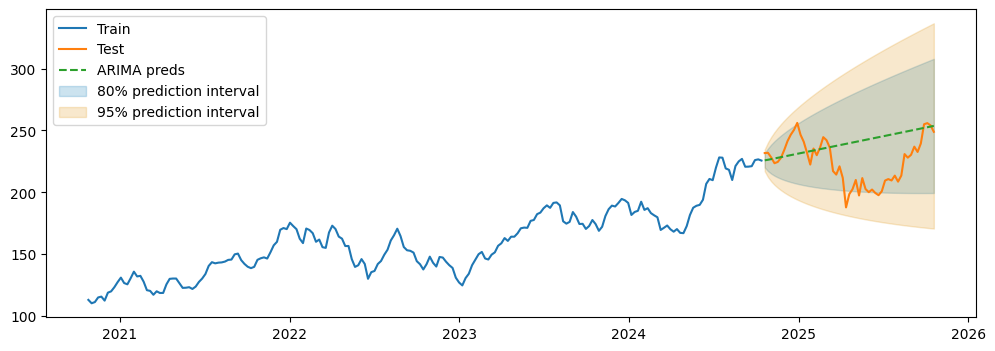

In [3]:
arima = ARIMA(order=(1, 1, 0)) 
fitted_vals, preds, intervals = fit_and_forecast(
    model=arima,
    time_series=data,      
    train_size=len(train),  
    horizon=len(test),
    coverage=[0.80, 0.95]        
)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(train.index, train, label='Train')
ax.plot(test.index, test, label='Test')
ax.plot(preds.index, preds, linestyle='--', label='ARIMA preds')
if intervals is not None:
    plot_interval(ax, intervals)
ax.legend()
plt.show()

What patterns does your model capture or miss?

Looking at the ARIMA(1,1,0) forecast for Apple stock prices:
- The model captures the general upward trend in the stock price, which is expected from a differenced model
- It misses the specific weekly fluctuations in the test set, producing a smoother forecast
- Major turning points in the price trajectory are not anticipated by the model
- The forecast becomes less accurate as we move further into the forecast horizon

80/95%
- Approximately 90% of the actual test values fall within the 80% prediction intervals, suggesting the model's uncertainty estimates are well-calibrated
- All test values fall within the wider 95% prediction intervals
- The intervals widen as the forecast extends further into the future, correctly reflecting increasing uncertainty


### 3. Perform residual analysis

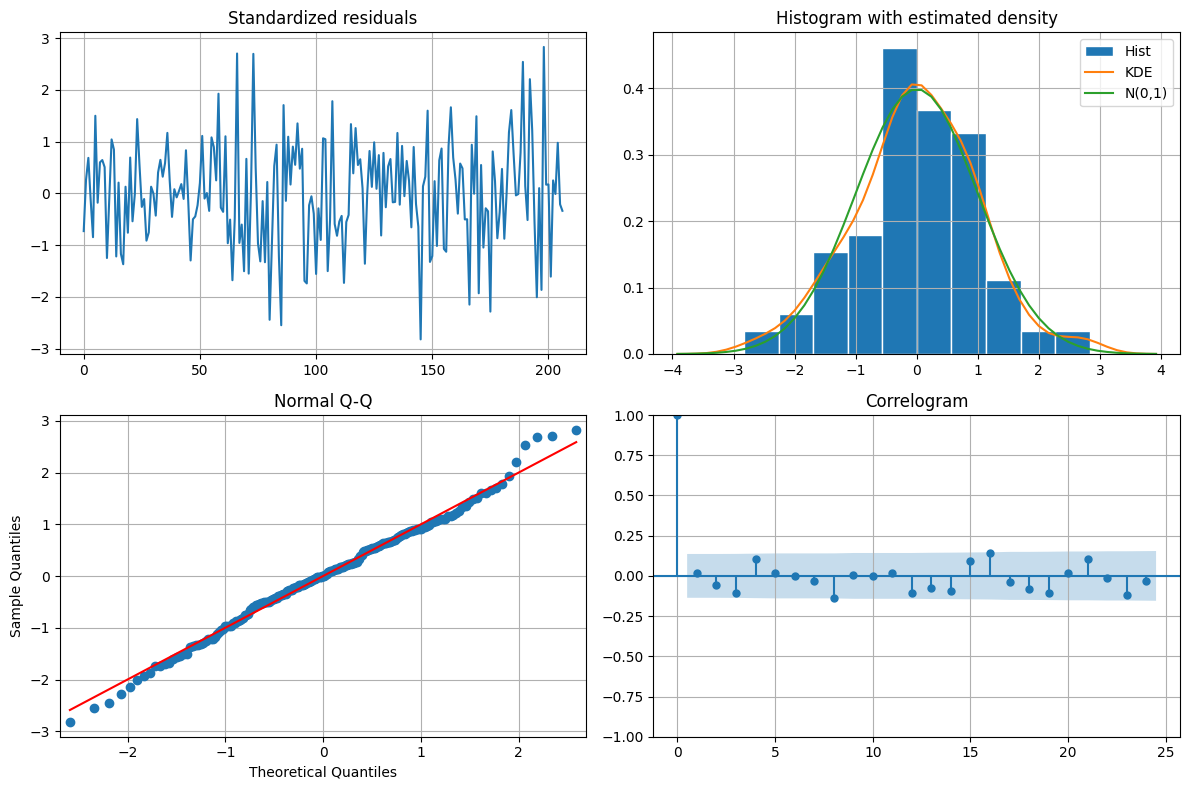

In [56]:
arima_residuals = train - arima.predict(train.index)
arima_residuals = arima_residuals.dropna()

standardized_residuals = arima_residuals.to_numpy().flatten() / np.std(arima_residuals.to_numpy())

residual_analysis_plots(standardized_residuals)

## Energy Consumption

### 1. Split real-world time series into train/test sets.

In [80]:
block_df = pd.read_parquet("01_Exercise/data/london_smart_meters/preprocessed/london_smart_meters_merged_block_0-7.parquet")

exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], 
                                  timeseries_col='energy_consumption', 
                                  static_cols=[], 
                                  time_varying_cols=[], 
                                  ts_identifier="LCLid")

data = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")["energy_consumption"].ffill()

window = slice("2012-10-06", "2012-10-10")
data = data[window]

full_train, (train, eval_set), test = split_time_series(data, valid_size=0, test_size=0.2)

100%|██████████| 50/50 [00:00<00:00, 1704.93it/s]


/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/ut

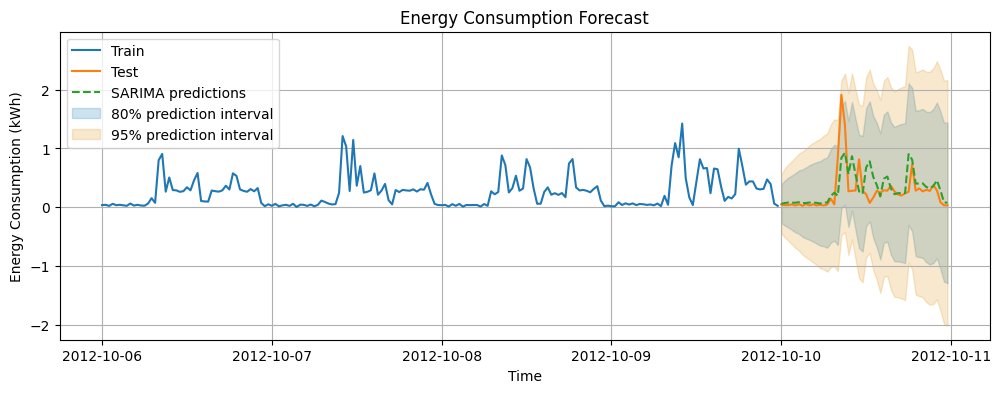

In [85]:
arima = ARIMA(order=(3, 1, 0), seasonal_order=(1, 1, 0, 48), suppress_warnings=True) # from last weeks
fitted_vals, preds, intervals = fit_and_forecast(
    model=arima,
    time_series=data,      
    train_size=len(train),  
    horizon=len(test),
    coverage=[0.80, 0.95]        
)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train.index, train, label='Train')
ax.plot(test.index, test, label='Test')
ax.plot(preds.index, preds, linestyle='--', label='SARIMA predictions')
if intervals is not None:
    plot_interval(ax, intervals)
ax.legend()
plt.title('Energy Consumption Forecast')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.grid(True)
plt.show()

For the energy consumption time series:
- The SARIMA model captures the overall trend in consumption but struggles with the high-frequency intraday patterns
- While it identifies some of the daily cyclical structure through the seasonal component, it fails to precisely predict the timing and magnitude of consumption peaks
- The forecasts exhibit less volatility than the actual data, suggesting the model is underestimating the variability in consumption

80/95%
- None of the actual consumption values fall outside both the 95% prediction interval.
- Appart from missing the highest consumption spike the rest falls into the 80%.

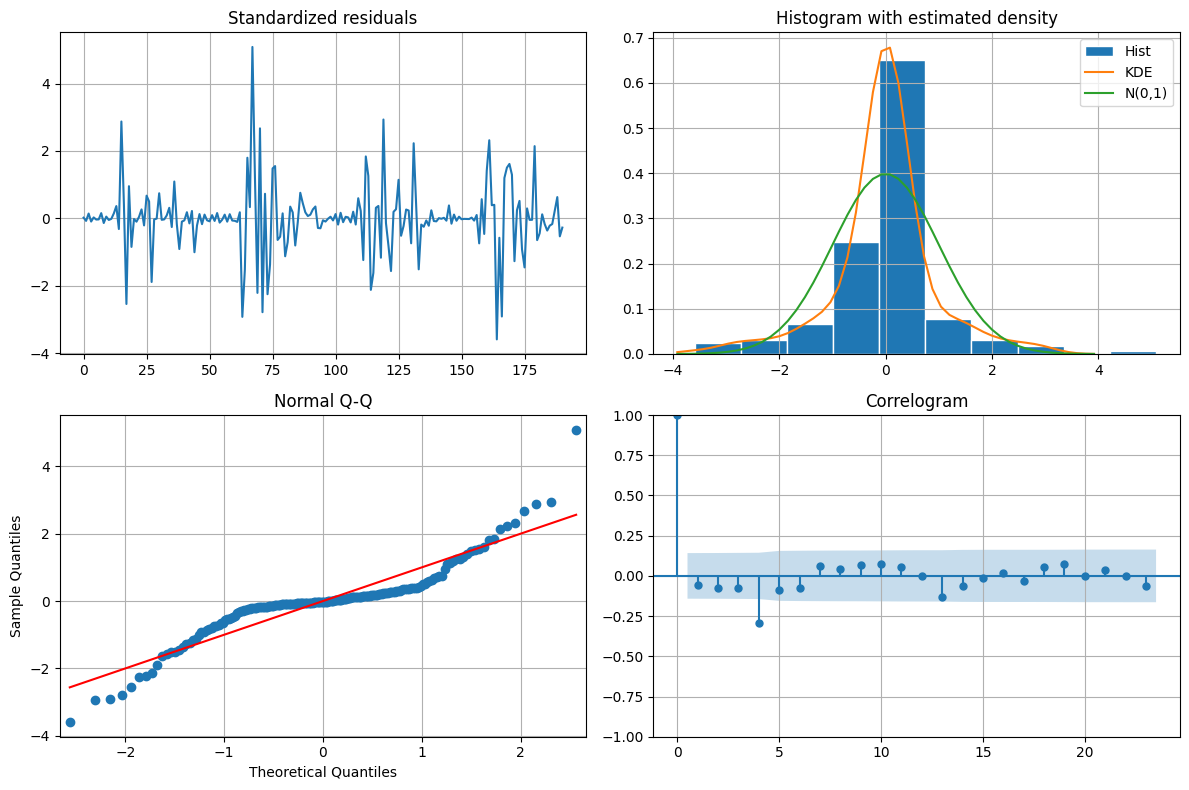

In [86]:
arima_residuals = train - arima.predict(train.index)
arima_residuals = arima_residuals.dropna()

standardized_residuals = arima_residuals.to_numpy().flatten() / np.std(arima_residuals.to_numpy())

residual_analysis_plots(standardized_residuals)

## Evaluation workflow

### Apple

/Users/sofiahorlacher/VisualStudio/time/notebooks/data.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', period='5y')
[*********************100%***********************]  1 of 1 completed
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_base.py:1250: Us

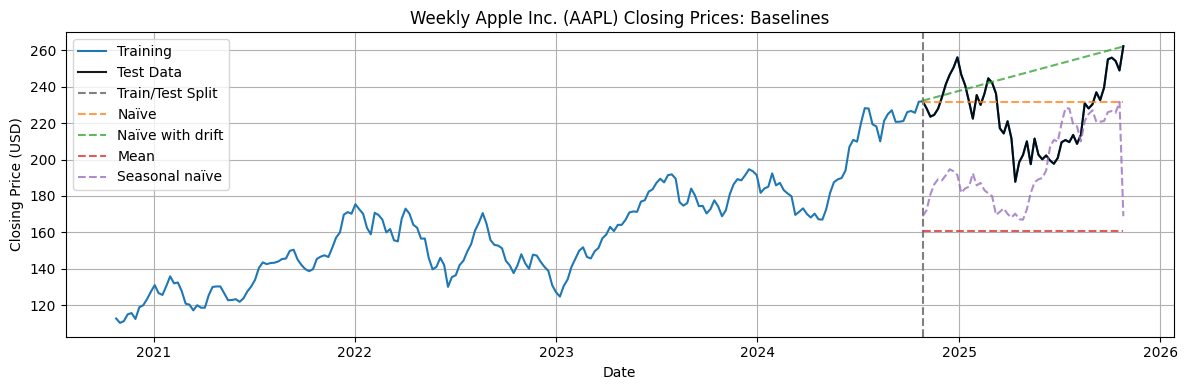

In [35]:
data = get_apple_5y().resample('W').mean().ffill()['Close']
full_train, (train, eval_set), test = split_time_series(data, valid_size=0, test_size=0.2)

fig, ax = time_plot(
    x=data.index,
    y=data,
    label="Training",
    title='Weekly Apple Inc. (AAPL) Closing Prices: Baselines',
    xlabel='Date',
    ylabel='Closing Price (USD)',
    return_fig=True,
)
ax.plot(test.index, test, label='Test Data', color='black', alpha=0.9)
ax.axvline(x=data.index[len(train)], color='gray', linestyle='--', label='Train/Test Split')

baselines = baseline_forecasting(data, len(train), period=52)
for name, (_, pred, _) in baselines.items():
    ax.plot(pred.index, pred, label=name, linestyle='--', alpha=0.75)

ax.legend(loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.split import ExpandingWindowSplitter
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

fh = np.arange(1, 5)
cv = ExpandingWindowSplitter(
    initial_window=int(len(full_train) * 0.6),
    step_length=len(fh), 
    fh=fh
)
models = {
    "ARIMA(1, 1, 0)": ARIMA(order=(1, 1, 0), suppress_warnings=True),
    "Naïve (Last)": NaiveForecaster(strategy="last"),
    "Naïve with Drift": NaiveForecaster(strategy="drift"),
    "Seasonal Naïve (sp=52)": NaiveForecaster(strategy="last", sp=52),
}

metrics = {
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'MAPE': mean_absolute_percentage_error
}

results = {name: {metric: [] for metric in metrics} for name in models}

for train_indices, test_indices in cv.split(full_train):
    train_fold = full_train.iloc[train_indices].asfreq('W')
    test_fold = full_train.iloc[test_indices]
    actuals = test_fold.iloc[:len(fh)]
    
    for name, forecaster in models.items():
        try:
            forecaster.fit(train_fold)
            pred = forecaster.predict(fh=fh)
            
            for metric_name, metric_func in metrics.items():
                value = metric_func(actuals, pred)
                results[name][metric_name].append(value)
        except:
            pass

avg_results = {}
for name, metrics_dict in results.items():
    avg_results[name] = {}
    for metric_name, values in metrics_dict.items():
        valid_values = [v for v in values if not np.isinf(v) and not np.isnan(v)]
        if valid_values:
            avg_results[name][metric_name] = np.mean(valid_values)

best_metric = 'MAPE'
best_model = min(avg_results, key=lambda k: avg_results[k].get(best_metric, np.inf))

print("\nModel Performance Summary:")
for name, metrics_dict in sorted(avg_results.items(), key=lambda x: x[1].get(best_metric, np.inf)):
    metrics_str = ", ".join([f"{m}: {metrics_dict.get(m, np.inf):.2f}" for m in metrics_dict])
    print(f"- {name}: {metrics_str}")


/Users/sofiahorlacher/VisualStudio/time/notebooks/data.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', period='5y')
[*********************100%***********************]  1 of 1 completed
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_


Model Performance Summary:
- ARIMA(1, 1, 0): RMSE: 6.78, MAPE: 0.03
- Naïve with Drift: RMSE: 6.90, MAPE: 0.03
- Naïve (Last): RMSE: 7.24, MAPE: 0.03
- Seasonal Naïve (sp=52): RMSE: 31.34, MAPE: 0.16


/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_f

The ARIMA(1, 1, 0) is the clear winner for forecasting the next 4 weeks of weekly Apple closing price, demonstrating that this particular data series contains a small amount of short-term autocorrelation that the model successfully exploits.

In [69]:
import pandas as pd

best_model_name = min(avg_results, key=lambda k: avg_results[k].get(best_metric, np.inf))
final_forecaster = models[best_model_name]

test_fh = np.array([1]) 
current_train = full_train.asfreq('W').copy() 
final_predictions = [] 

for i in range(len(test)):
    final_forecaster.fit(current_train)
    pred = final_forecaster.predict(fh=test_fh)
    final_predictions.append(pred.iloc[0]) 
    new_data_point = test.iloc[[i]].asfreq('W') 
    current_train = pd.concat([current_train, new_data_point])

final_pred_series = pd.Series(final_predictions, index=test.index)

final_performance = {}
for metric_name, metric_func in metrics.items():
    value = metric_func(test, final_pred_series) 
    final_performance[metric_name] = value
    
print("\n--- Final Test Set Performance (Rolling 1-Week Forecast) ---")
print(f"Best Model Selected: {best_model_name}")
metrics_str = ", ".join([f"{m}: {v:.2f}" for m, v in final_performance.items()])
print(f"Performance on Held-Out Test Set: {metrics_str}")

/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/ut


--- Final Test Set Performance (Rolling 1-Week Forecast) ---
Best Model Selected: ARIMA(1, 1, 0)
Performance on Held-Out Test Set: RMSE: 8.47, MAPE: 0.03


### Energy

100%|██████████| 50/50 [00:00<00:00, 1766.16it/s]
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_ta

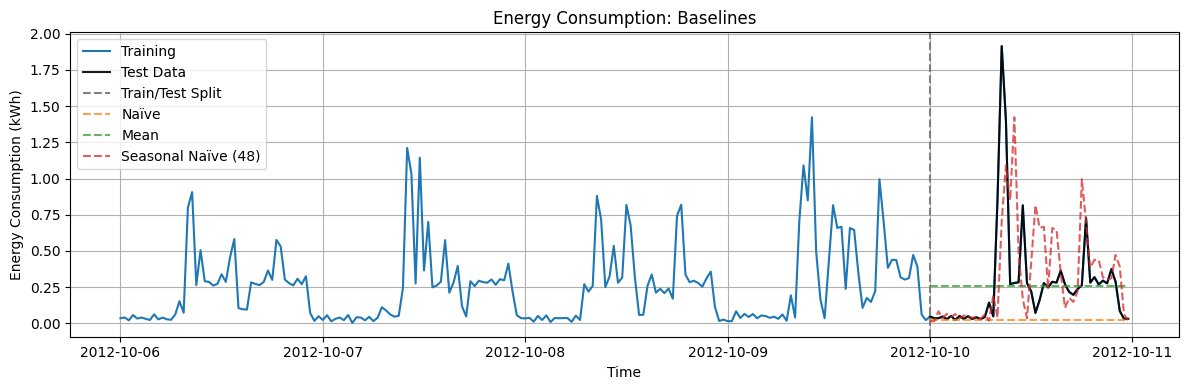

In [105]:
import numpy as np
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.split import ExpandingWindowSplitter
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, MeanAbsoluteScaledError
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_error

block_df = pd.read_parquet("01_Exercise/data/london_smart_meters/preprocessed/london_smart_meters_merged_block_0-7.parquet")

exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], 
                                  timeseries_col='energy_consumption', 
                                  static_cols=[], 
                                  time_varying_cols=[], 
                                  ts_identifier="LCLid")

data = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")["energy_consumption"].ffill()

window = slice("2012-10-06", "2012-10-10")
data = data[window]

data = data.asfreq('30min')

full_train, (train, _), test = split_time_series(data, valid_size=0, test_size=0.2)

fig, ax = time_plot(
    x=data.index,
    y=data,
    label="Training",
    title='Energy Consumption: Baselines',
    xlabel='Time',
    ylabel='Energy Consumption (kWh)',
    return_fig=True,
)
ax.plot(test.index, test, label='Test Data', color='black', alpha=0.9)
ax.axvline(x=data.index[len(train)], color='gray', linestyle='--', label='Train/Test Split')

baselines = {
    "Naïve": NaiveForecaster(strategy="last"),
    "Mean": NaiveForecaster(strategy="mean"),
    "Seasonal Naïve (48)": NaiveForecaster(strategy="last", sp=48)
}

for name, forecaster in baselines.items():
    try:
        forecaster.fit(train)
        pred = forecaster.predict(fh=np.arange(1, len(test) + 1))
        ax.plot(pred.index, pred, label=name, linestyle='--', alpha=0.75)
    except Exception as e:
        print(f"Error with {name}: {str(e)}")

ax.legend(loc='upper left')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
    MeanSquaredError,
    MeanAbsoluteError
)

fh = np.arange(1, 13)

cv = ExpandingWindowSplitter(
    initial_window=int(len(full_train) * 0.6),
    step_length=len(fh), 
    fh=fh
)

models = {
    "SARIMA(3, 1, 0)(1, 1, 0, 48)": ARIMA(order=(3, 1, 0), seasonal_order=(1, 1, 0, 48), suppress_warnings=True),
    "Naïve (Last)": NaiveForecaster(strategy="last"),
    "Seasonal Naïve (sp=48)": NaiveForecaster(strategy="last", sp=48)  
}

mape_scorer = MeanAbsolutePercentageError()
mase_scorer = MeanAbsoluteScaledError(sp=48)  # seasonal period = 48
rmse_scorer = MeanSquaredError(square_root=True)
mae_scorer = MeanAbsoluteError()

metrics = {
    'RMSE': rmse_scorer,
    'MAPE': mape_scorer,
    'MASE': mase_scorer,
    'MAE': mae_scorer
}

results = {name: {metric: [] for metric in metrics} for name in models}

fold_count = 0
for train_indices, test_indices in cv.split(full_train):
    fold_count += 1
    train_fold = full_train.iloc[train_indices]
    test_fold = full_train.iloc[test_indices]
    
    if len(test_fold) < len(fh):
        print(f"Skipping fold {fold_count}: insufficient test data ({len(test_fold)} < {len(fh)})")
        continue
        
    actuals = test_fold.iloc[:len(fh)]
    
    for name, forecaster in models.items():
        try:
            forecaster.fit(train_fold)
            
            pred = forecaster.predict(fh=fh)
            
            if len(pred) != len(actuals):
                print(f"Length mismatch in {name}, fold {fold_count}: pred={len(pred)}, actuals={len(actuals)}")
                continue
                
            for metric_name, scorer in metrics.items():
                if metric_name == 'MASE':
                    score = scorer(actuals, pred, y_train=train_fold)
                else:
                    score = scorer(actuals, pred)
                
                if np.isfinite(score):
                    results[name][metric_name].append(score)
                else:
                    print(f"Non-finite {metric_name} in {name}, fold {fold_count}: {score}")
                    
        except Exception as e:
            print(f"Error in {name}, fold {fold_count}: {str(e)}")

avg_results = {}
for name, metrics_dict in results.items():
    avg_results[name] = {}
    for metric_name, values in metrics_dict.items():
        if values:
            avg_results[name][metric_name] = np.mean(values)
        else:
            avg_results[name][metric_name] = np.inf

best_metric = 'MAPE'
best_model = min(avg_results, key=lambda k: avg_results[k].get(best_metric, np.inf))

print("\nModel Performance Summary for Energy Consumption:")
for metric_name in metrics:
    print(f"\nBest model based on {metric_name}:")
    sorted_models = sorted(avg_results, key=lambda k: avg_results[k].get(metric_name, np.inf))
    for name in sorted_models:
        val = avg_results[name].get(metric_name, np.inf)
        print(f"- {name}: {val:.4f}")

/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_value


Model Performance Summary for Energy Consumption:

Best model based on RMSE:
- Seasonal Naïve (sp=48): 0.2395
- SARIMA(3, 1, 0)(1, 1, 0, 48): 0.3246
- Naïve (Last): 0.3566

Best model based on MAPE:
- Seasonal Naïve (sp=48): 1.0064
- SARIMA(3, 1, 0)(1, 1, 0, 48): 1.8566
- Naïve (Last): 2.5888

Best model based on MASE:
- Seasonal Naïve (sp=48): 1.1118
- SARIMA(3, 1, 0)(1, 1, 0, 48): 1.6225
- Naïve (Last): 1.8207

Best model based on MAE:
- Seasonal Naïve (sp=48): 0.1779
- SARIMA(3, 1, 0)(1, 1, 0, 48): 0.2606
- Naïve (Last): 0.2944


/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)


/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/lib/python3.9/site-packages/skbase/base/_base.py:1342: FutureWarning: tag 'handles-missing-data' will be removed in sktime version 1.0.0 and replaced by 'capability:missing_values', please use 'capability:missing_values' instead
  self._deprecate_tag_warn(collected_tags)
/Users/sofiahorlacher/VisualStudio/time/.venv/


--- Final Test Set Performance (Rolling 1-Step Forecast) ---
Best Model Selected: Seasonal Naïve (sp=48)
Performance on Held-Out Test Set: RMSE: 0.3666, MAPE: 1.0829, MAE: 0.2156


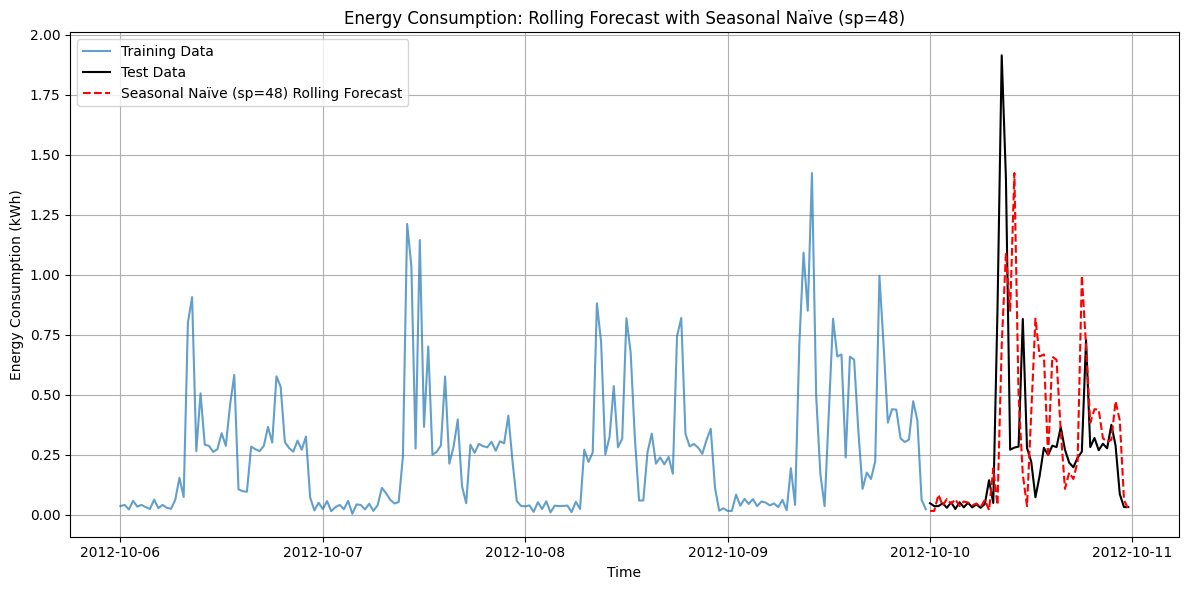

In [109]:
best_model_name = min(avg_results, key=lambda k: avg_results[k].get(best_metric, np.inf))
final_forecaster = models[best_model_name]

test_fh = np.array([1])  
current_train = full_train.copy() 
final_predictions = [] 

for i in range(len(test)):    
    final_forecaster.fit(current_train)
    pred = final_forecaster.predict(fh=test_fh)
    final_predictions.append(pred.iloc[0]) 
    new_data_point = test.iloc[[i]] 
    current_train = pd.concat([current_train, new_data_point])

final_pred_series = pd.Series(final_predictions, index=test.index)

final_performance = {}
for metric_name, metric_func in metrics.items():
    try:
        value = metric_func(test, final_pred_series) 
        final_performance[metric_name] = value
    except:
        final_performance[metric_name] = np.nan
    
print("\n--- Final Test Set Performance (Rolling 1-Step Forecast) ---")
print(f"Best Model Selected: {best_model_name}")
metrics_str = ", ".join([f"{m}: {v:.4f}" for m, v in final_performance.items() if not np.isnan(v)])
print(f"Performance on Held-Out Test Set: {metrics_str}")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train, label='Training Data', alpha=0.7)
ax.plot(test.index, test, label='Test Data', color='black')
ax.plot(final_pred_series.index, final_pred_series, label=f'{best_model_name} Rolling Forecast', 
         linestyle='--', color='red')
ax.set_title(f'Energy Consumption: Rolling Forecast with {best_model_name}')
ax.set_xlabel('Time')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Based on the evaluation results, the Seasonal Naïve (sp=48) model provides the best forecasting performance for the energy consumption data, as evidenced by its superior RMSE (0.2395) and MAPE (1.0064) scores compared to the other models. This demonstrates that for this particular household energy data, simply using the consumption pattern from the previous day is remarkably effective.

The strong performance of seasonality-based forecasting methods (both Seasonal Naïve and SARIMA) confirms that daily seasonality is a crucial feature of residential energy consumption patterns. This makes sense intuitively, as households tend to follow regular daily routines in their energy usage.